In [1]:
import numpy as np
import pandas as pd

# '초기 이탈' ,중기 이탈, '후기 이탈'은 원인이 다르다. 
# 하나의 캠페인으로 전체 이탈을 줄일 수 없음. 각 스테이지 별 주요 변수 확인

# 데이터 불러오기

In [2]:
df = pd.read_csv('data/cust_data_v1.csv')
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,NaN,0.0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,NaN,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0.0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0.0,No,No,2,Yes,No,DSL,Yes,...,NaN,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0.0,No,No,45,No,No phone service,DSL,Yes,...,NaN,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0.0,No,No,2,Yes,No,Fiber optic,No,...,NaN,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0.0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0.0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0.0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1.0,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [7]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7034 non-null   object 
 2   SeniorCitizen     7042 non-null   float64
 3   Partner           7043 non-null   object 
 4   Dependents        7041 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7040 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  3580 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7042 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


# 데이터 전처리 및 시각화

In [7]:

# ----------------------------
# 0) 기본 전처리
# ----------------------------
df = df.copy()

# 타깃
df["Churn01"] = df["Churn"].map({"Yes": 1, "No": 0})

# TotalCharges 숫자 변환(공백/문자 혼입 대응)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# 결측 보정(분석용: 최소한의 처리)
df["TotalCharges"] = df["TotalCharges"].fillna(df["TotalCharges"].median())

# tenure stage
bins = [-1, 3, 12, np.inf]
labels = ["early(0-3)", "mid(4-12)", "late(13+)"]
df["tenure_stage"] = pd.cut(df["tenure"], bins=bins, labels=labels)

# ----------------------------
# 1) 인덱스(축약 변수) 만들기
# ----------------------------
bundle_cols = ["OnlineSecurity", "OnlineBackup", "DeviceProtection",
               "TechSupport", "StreamingTV", "StreamingMovies"]

sec_support_cols = ["OnlineSecurity", "TechSupport", "DeviceProtection"]
ent_cols = ["StreamingTV", "StreamingMovies"]

def yes_to_1(x):
    # Yes -> 1, 그 외(No, No internet service 등) -> 0
    return (x == "Yes").astype(int)

# Bundling Index: Yes 개수(0~6)
df["bundling_index"] = df[bundle_cols].apply(yes_to_1).sum(axis=1)

# Security-Support Index: Yes 개수(0~3)
df["security_support_index"] = df[sec_support_cols].apply(yes_to_1).sum(axis=1)

# Entertainment Index: Yes 개수(0~2)
df["entertainment_index"] = df[ent_cols].apply(yes_to_1).sum(axis=1)

# Friction Index: 불안정 조합 점수(0~3)
df["friction_score"] = (
    (df["Contract"] == "Month-to-month").astype(int)
    + (df["PaymentMethod"] == "Electronic check").astype(int)
    + (df["PaperlessBilling"] == "Yes").astype(int)
)

# 불안정 조합 여부(3개 모두 만족이면 1)
df["friction_flag"] = (
    (df["Contract"] == "Month-to-month")
    & (df["PaymentMethod"] == "Electronic check")
    & (df["PaperlessBilling"] == "Yes")
).astype(int)

# Value Gap Proxy: "번들 대비 요금이 비싼가?"
# 방법: 같은 bundling_index 그룹 내 평균 월요금 대비 얼마나 비싼지(+) / 싼지(-)
group_mean = df.groupby("bundling_index")["MonthlyCharges"].transform("mean")
df["value_gap"] = df["MonthlyCharges"] - group_mean

# (선택) 비교 편하게 표준화 버전도 추가
df["value_gap_z"] = df.groupby("bundling_index")["MonthlyCharges"].transform(
    lambda s: (s - s.mean()) / (s.std(ddof=0) if s.std(ddof=0) != 0 else 1)
)

df[["tenure_stage","Churn","bundling_index","security_support_index",
    "entertainment_index","friction_score","friction_flag","MonthlyCharges","value_gap"]]


,tenure_stage,Churn,bundling_index,security_support_index,entertainment_index,friction_score,friction_flag,MonthlyCharges,value_gap
0,early(0-3),No,1,0,0,2,0,29.85,-36.381103
1,late(13+),No,2,2,0,0,0,56.95,-17.522266
2,early(0-3),Yes,2,1,0,2,0,53.85,-20.622266
3,late(13+),No,2,2,0,0,0,42.30,-32.172266
4,early(0-3),Yes,0,0,0,3,1,70.70,37.137994
...,...,...,...,...,...,...,...,...,...
7038,late(13+),No,5,3,2,1,0,84.80,-9.867201
7039,late(13+),No,4,1,2,1,0,103.20,14.248882
7040,mid(4-12),No,1,1,0,3,1,29.60,-36.631103
7041,mid(4-12),Yes,0,0,0,2,0,74.40,40.837994


C:\Users\Admin\AppData\Local\Temp\ipykernel_10952\865458398.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stage_rate = (df.groupby("tenure_stage")["Churn01"].mean() * 100).reset_index()
C:\Users\Admin\AppData\Local\Temp\ipykernel_10952\865458398.py:12: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_10952\865458398.py:12: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_10952\865458398.py:12: UserWarning: Glyph 53448 (\N{HANGUL SYLLABLE TAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_10952\865458398.py:12: UserWarning: Glyph 47456 (\N{H

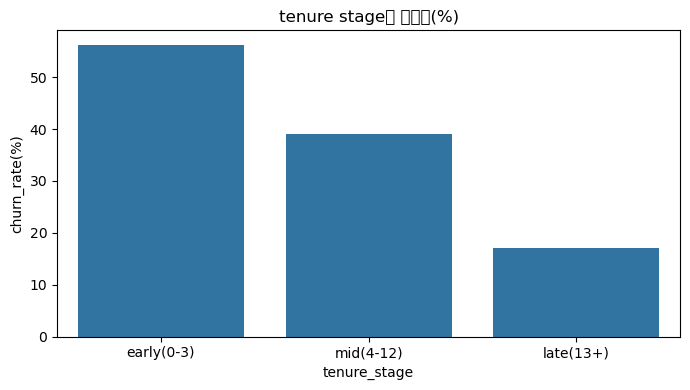

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

stage_rate = (df.groupby("tenure_stage")["Churn01"].mean() * 100).reset_index()
stage_rate.columns = ["tenure_stage", "churn_rate"]

plt.figure(figsize=(7,4))
sns.barplot(data=stage_rate, x="tenure_stage", y="churn_rate")
plt.title("tenure stage별 이탈률(%)")
plt.xlabel("tenure_stage")
plt.ylabel("churn_rate(%)")
plt.tight_layout()
plt.show()


In [ ]:
# stage 별 요약 테이블

idx_cols = ["bundling_index", "security_support_index", "entertainment_index",
            "friction_score", "friction_flag", "MonthlyCharges", "value_gap"]

stage_summary = (
    df.groupby("tenure_stage")
      .agg(n=("Churn01","size"),
           churn_rate=("Churn01","mean"),
           **{c:(c,"mean") for c in idx_cols})
      .reset_index()
)

stage_summary["churn_rate"] = (stage_summary["churn_rate"]*100).round(2)
for c in idx_cols:
    stage_summary[c] = stage_summary[c].round(3)

stage_summary


C:\Users\Admin\AppData\Local\Temp\ipykernel_12704\3427162325.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("tenure_stage")


,tenure_stage,n,churn_rate,bundling_index,security_support_index,entertainment_index,friction_score,friction_flag,MonthlyCharges,value_gap
0,early(0-3),1062,56.21,0.693,0.234,0.343,2.009,0.330,53.316,3.686
1,mid(4-12),1124,39.15,1.185,0.439,0.553,1.889,0.311,58.731,0.861
2,late(13+),4857,17.13,2.289,0.942,0.917,1.267,0.143,68.661,-1.005


In [5]:
# 분위수 구간(중복값 많으면 duplicates="drop" 필요)
df["monthly_bin"] = pd.qcut(df["MonthlyCharges"], q=5, duplicates="drop")
df["valuegap_bin"] = pd.qcut(df["value_gap"], q=5, duplicates="drop")


In [6]:
def churn_lift_table(df, stage, col, min_count=50):
    d = df[df["tenure_stage"] == stage].copy()
    base = d["Churn01"].mean()

    t = (d.groupby(col)["Churn01"]
           .agg(count="size", churn_rate="mean")
           .reset_index())
    t = t[t["count"] >= min_count].copy()

    t["lift_vs_stage(pp)"] = (t["churn_rate"] - base) * 100
    t["churn_rate(%)"] = t["churn_rate"] * 100
    t = t.sort_values("lift_vs_stage(pp)", ascending=False)

    t["churn_rate(%)"] = t["churn_rate(%)"].round(2)
    t["lift_vs_stage(pp)"] = t["lift_vs_stage(pp)"].round(2)

    return base*100, t

stages = ["early(0-3)", "mid(4-12)", "late(13+)"]
cols_to_scan = ["bundling_index", "security_support_index", "entertainment_index",
                "friction_score", "friction_flag", "monthly_bin", "valuegap_bin"]

for s in stages:
    print(f"\n=== {s} ===")
    for c in cols_to_scan:
        base, tab = churn_lift_table(df, s, c, min_count=30)
        print(f"\n[{c}] stage avg churn={base:.2f}%")
        display(tab.head(8))



=== early(0-3) ===

[bundling_index] stage avg churn=56.21%


,bundling_index,count,churn_rate,lift_vs_stage(pp),churn_rate(%)
2,2,131,0.664122,10.20,66.41
1,1,256,0.652344,9.02,65.23
3,3,49,0.612245,5.01,61.22
0,0,609,0.507389,-5.48,50.74



[security_support_index] stage avg churn=56.21%


,security_support_index,count,churn_rate,lift_vs_stage(pp),churn_rate(%)
1,1,168,0.583333,2.12,58.33
0,0,855,0.570760,0.86,57.08
2,2,37,0.297297,-26.48,29.73



[entertainment_index] stage avg churn=56.21%


,entertainment_index,count,churn_rate,lift_vs_stage(pp),churn_rate(%)
2,2,89,0.719101,15.70,71.91
1,1,186,0.715054,15.29,71.51
0,0,787,0.508259,-5.39,50.83



[friction_score] stage avg churn=56.21%


,friction_score,count,churn_rate,lift_vs_stage(pp),churn_rate(%)
3,3,350,0.771429,20.93,77.14
2,2,401,0.553616,-0.85,55.36
1,1,282,0.365248,-19.69,36.52



[friction_flag] stage avg churn=56.21%


,friction_flag,count,churn_rate,lift_vs_stage(pp),churn_rate(%)
1,1,350,0.771429,20.93,77.14
0,0,712,0.459270,-10.29,45.93



[monthly_bin] stage avg churn=56.21%


C:\Users\Admin\AppData\Local\Temp\ipykernel_12704\271156716.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  t = (d.groupby(col)["Churn01"]


,monthly_bin,count,churn_rate,lift_vs_stage(pp),churn_rate(%)
4,"(94.25, 118.75]",40,0.775000,21.29,77.50
3,"(79.1, 94.25]",160,0.768750,20.66,76.88
2,"(58.85, 79.1]",277,0.693141,13.10,69.31
1,"(25.05, 58.85]",307,0.540717,-2.14,54.07
0,"(18.249, 25.05]",278,0.305755,-25.64,30.58



[valuegap_bin] stage avg churn=56.21%


C:\Users\Admin\AppData\Local\Temp\ipykernel_12704\271156716.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  t = (d.groupby(col)["Churn01"]


,valuegap_bin,count,churn_rate,lift_vs_stage(pp),churn_rate(%)
4,"(16.797, 47.688]",254,0.791339,22.92,79.13
3,"(10.833, 16.797]",213,0.704225,14.21,70.42
2,"(-10.574, 10.833]",157,0.541401,-2.07,54.14
0,"(-44.492999999999995, -14.262]",179,0.452514,-10.96,45.25
1,"(-14.262, -10.574]",259,0.308880,-25.33,30.89



=== mid(4-12) ===

[bundling_index] stage avg churn=39.15%


,bundling_index,count,churn_rate,lift_vs_stage(pp),churn_rate(%)
1,1,271,0.490775,9.93,49.08
3,3,138,0.485507,9.40,48.55
2,2,221,0.484163,9.27,48.42
4,4,36,0.472222,8.08,47.22
0,0,446,0.251121,-14.03,25.11



[security_support_index] stage avg churn=39.15%


,security_support_index,count,churn_rate,lift_vs_stage(pp),churn_rate(%)
0,0,745,0.400000,0.85,40.00
1,1,278,0.399281,0.78,39.93
2,2,88,0.295455,-9.60,29.55



[entertainment_index] stage avg churn=39.15%


,entertainment_index,count,churn_rate,lift_vs_stage(pp),churn_rate(%)
2,2,175,0.662857,27.14,66.29
1,1,272,0.477941,8.65,47.79
0,0,677,0.286558,-10.49,28.66



[friction_score] stage avg churn=39.15%


,friction_score,count,churn_rate,lift_vs_stage(pp),churn_rate(%)
3,3,350,0.585714,19.43,58.57
2,2,397,0.420655,2.92,42.07
1,1,279,0.225806,-16.57,22.58
0,0,98,0.051020,-34.04,5.10



[friction_flag] stage avg churn=39.15%


,friction_flag,count,churn_rate,lift_vs_stage(pp),churn_rate(%)
1,1,350,0.585714,19.43,58.57
0,0,774,0.303618,-8.78,30.36



[monthly_bin] stage avg churn=39.15%


C:\Users\Admin\AppData\Local\Temp\ipykernel_12704\271156716.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  t = (d.groupby(col)["Churn01"]


,monthly_bin,count,churn_rate,lift_vs_stage(pp),churn_rate(%)
4,"(94.25, 118.75]",108,0.805556,41.41,80.56
3,"(79.1, 94.25]",223,0.641256,24.98,64.13
2,"(58.85, 79.1]",262,0.389313,-0.21,38.93
1,"(25.05, 58.85]",278,0.298561,-9.29,29.86
0,"(18.249, 25.05]",252,0.099206,-29.23,9.92



[valuegap_bin] stage avg churn=39.15%


C:\Users\Admin\AppData\Local\Temp\ipykernel_12704\271156716.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  t = (d.groupby(col)["Churn01"]


,valuegap_bin,count,churn_rate,lift_vs_stage(pp),churn_rate(%)
4,"(16.797, 47.688]",241,0.684647,29.32,68.46
3,"(10.833, 16.797]",222,0.576577,18.51,57.66
2,"(-10.574, 10.833]",172,0.348837,-4.26,34.88
0,"(-44.492999999999995, -14.262]",237,0.257384,-13.41,25.74
1,"(-14.262, -10.574]",251,0.103586,-28.79,10.36



=== late(13+) ===

[bundling_index] stage avg churn=17.13%


,bundling_index,count,churn_rate,lift_vs_stage(pp),churn_rate(%)
1,1,534,0.288390,11.71,28.84
2,2,783,0.257982,8.67,25.80
3,3,974,0.223819,5.25,22.38
4,4,755,0.157616,-1.37,15.76
5,5,454,0.107930,-6.34,10.79
0,0,1223,0.069501,-10.18,6.95
6,6,134,0.037313,-13.40,3.73



[security_support_index] stage avg churn=17.13%


,security_support_index,count,churn_rate,lift_vs_stage(pp),churn_rate(%)
1,1,1365,0.213187,4.19,21.32
0,0,2061,0.193110,2.18,19.31
2,2,1083,0.116343,-5.50,11.63
3,3,348,0.048851,-12.24,4.89



[entertainment_index] stage avg churn=17.13%


,entertainment_index,count,churn_rate,lift_vs_stage(pp),churn_rate(%)
2,2,1676,0.233294,6.20,23.33
1,1,1101,0.206176,3.49,20.62
0,0,2080,0.102885,-6.84,10.29



[friction_score] stage avg churn=17.13%


,friction_score,count,churn_rate,lift_vs_stage(pp),churn_rate(%)
3,3,696,0.475575,30.43,47.56
2,2,1190,0.254622,8.33,25.46
1,1,1685,0.093769,-7.75,9.38
0,0,1286,0.031104,-14.02,3.11



[friction_flag] stage avg churn=17.13%


,friction_flag,count,churn_rate,lift_vs_stage(pp),churn_rate(%)
1,1,696,0.475575,30.43,47.56
0,0,4161,0.120404,-5.09,12.04



[monthly_bin] stage avg churn=17.13%


C:\Users\Admin\AppData\Local\Temp\ipykernel_12704\271156716.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  t = (d.groupby(col)["Churn01"]


,monthly_bin,count,churn_rate,lift_vs_stage(pp),churn_rate(%)
4,"(94.25, 118.75]",1260,0.273016,10.17,27.30
3,"(79.1, 94.25]",1024,0.236328,6.50,23.63
2,"(58.85, 79.1]",870,0.144828,-2.65,14.48
1,"(25.05, 58.85]",813,0.123001,-4.83,12.30
0,"(18.249, 25.05]",890,0.022472,-14.88,2.25



[valuegap_bin] stage avg churn=17.13%


C:\Users\Admin\AppData\Local\Temp\ipykernel_12704\271156716.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  t = (d.groupby(col)["Churn01"]


,valuegap_bin,count,churn_rate,lift_vs_stage(pp),churn_rate(%)
4,"(16.797, 47.688]",914,0.345733,17.44,34.57
3,"(10.833, 16.797]",971,0.279094,10.78,27.91
2,"(-10.574, 10.833]",1081,0.103608,-6.77,10.36
0,"(-44.492999999999995, -14.262]",1001,0.100899,-7.04,10.09
1,"(-14.262, -10.574]",890,0.035955,-13.53,3.60


In [5]:
import numpy as np
import pandas as pd

df = df.copy()

# 타깃(0/1)
df["Churn01"] = df["Churn"].map({"Yes": 1, "No": 0})

# early 구간만
df_e = df[df["tenure_stage"] == "early(0-3)"].copy()

# 대안 1: friction_flag 제거
X_cols = ["bundling_index", "security_support_index", "entertainment_index", "friction_score"]

X = df_e[X_cols].astype(float)
y = df_e["Churn01"].astype(int)

print("[INFO] early rows:", len(df_e), "| churn_rate(%):", round(y.mean()*100, 2))


[INFO] early rows: 1062 | churn_rate(%): 56.21


In [6]:
import statsmodels.api as sm

X_sm = sm.add_constant(X)  # 절편 추가
logit = sm.Logit(y, X_sm).fit(disp=False)

print(logit.summary())

# 오즈비(OR) 테이블
or_table = pd.DataFrame({
    "coef": logit.params,
    "odds_ratio(OR)": np.exp(logit.params),
    "p_value": logit.pvalues
}).sort_values("p_value")

or_table


                           Logit Regression Results                           
Dep. Variable:                Churn01   No. Observations:                 1062
Model:                          Logit   Df Residuals:                     1057
Method:                           MLE   Df Model:                            4
Date:                Tue, 10 Feb 2026   Pseudo R-squ.:                  0.1076
Time:                        11:45:08   Log-Likelihood:                -649.56
converged:                       True   LL-Null:                       -727.90
Covariance Type:            nonrobust   LLR p-value:                 7.522e-33
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -1.4751      0.180     -8.179      0.000      -1.829      -1.122
bundling_index            -0.2128      0.208     -1.024      0.306      -0.620       0.195
secu

,coef,odds_ratio(OR),p_value
friction_score,0.866729,2.379116,1.798145e-23
const,-1.475051,0.228767,2.873687e-16
entertainment_index,0.600826,1.823625,1.521700e-02
bundling_index,-0.212819,0.808302,3.059654e-01
security_support_index,-0.159979,0.852162,5.396969e-01


### (1) friction_score — 가장 강력한 early 이탈 원인

coef = 0.8667 (양수)

OR = 2.379

p-value ≈ 1.8e-23 (매우 유의)


friction_score가 1점 증가할 때마다(0→1, 1→2처럼)
이탈 오즈(odds)가 2.38배로 증가.
즉 early 구간에서 결제/청구/계약 마찰(월단위+전자수표+페이퍼리스)이 이탈을 크게 밀어 올림.


* Month-to-month 자체가 언제든 나갈 수 있는 계약입니다.

* Electronic check는 자동이체/카드 자동결제보다 유지 관성이 약함(매번 결제/잔액/승인 과정이 있음).

* PaperlessBilling=Yes는 가입/청구/결제가 디지털 채널 중심으로 진행되는 성격이 강해, 경쟁사로 이동도 쉽습니다.

### (2) entertainment_index — early 이탈을 높이는 방향(의외 포인트)

coef = 0.6008 (양수)

OR = 1.824

p-value = 0.015 (유의)


스트리밍(StreamingTV/Movies) 옵션이 Yes가 1개 늘어날 때마다
이탈 오즈가 약 1.82배 증가.

해석 시나리오(현실적인 해석)
엔터 옵션은 보통 **요금 상승(MonthlyCharges↑)**과 같이 움직일 가능성이 큼
→ 지금 모델엔 MonthlyCharges가 없으니 “비싸서 이탈”의 신호가 엔터 인덱스로 잡혔을 수 있음.
또는 early 고객에서 엔터 번들은 “기대치만 키우고 만족을 못 하면” 이탈로 이어질 수 있음.

In [9]:
import numpy as np
import pandas as pd

df = df.copy()

# 타깃(0/1)
df["Churn01"] = df["Churn"].map({"Yes": 1, "No": 0})

# mid 구간만
df_m = df[df["tenure_stage"] == "mid(4-12)"].copy()

X_cols = ["bundling_index", "security_support_index", "entertainment_index", "friction_score"]
X = df_m[X_cols].astype(float)
y = df_m["Churn01"].astype(int)

print("[INFO] mid rows:", len(df_m), "| churn_rate(%):", round(y.mean()*100, 2))


[INFO] mid rows: 1124 | churn_rate(%): 39.15


In [10]:
import statsmodels.api as sm

X_sm = sm.add_constant(X)
logit_mid = sm.Logit(y, X_sm).fit(disp=False)

print(logit_mid.summary())

or_mid = pd.DataFrame({
    "coef": logit_mid.params,
    "odds_ratio(OR)": np.exp(logit_mid.params),
    "p_value": logit_mid.pvalues
}).sort_values("p_value")

or_mid


                           Logit Regression Results                           
Dep. Variable:                Churn01   No. Observations:                 1124
Model:                          Logit   Df Residuals:                     1119
Method:                           MLE   Df Model:                            4
Date:                Tue, 10 Feb 2026   Pseudo R-squ.:                  0.1290
Time:                        12:13:31   Log-Likelihood:                -655.33
converged:                       True   LL-Null:                       -752.40
Covariance Type:            nonrobust   LLR p-value:                 6.801e-41
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -2.1370      0.183    -11.667      0.000      -2.496      -1.778
bundling_index             0.0238      0.169      0.141      0.888      -0.307       0.354
secu

,coef,odds_ratio(OR),p_value
const,-2.136951,0.118014,1.882641e-31
friction_score,0.721945,2.058433,4.995649e-19
entertainment_index,0.600283,1.822635,2.392909e-03
security_support_index,-0.263105,0.768661,2.011906e-01
bundling_index,0.023781,1.024066,8.879014e-01


In [13]:
import numpy as np
import pandas as pd

df = df.copy()

# 타깃(0/1)
df["Churn01"] = df["Churn"].map({"Yes": 1, "No": 0})

# late 구간만
df_l = df[df["tenure_stage"] == "late(13+)"].copy()

X_cols = ["bundling_index", "security_support_index", "entertainment_index", "friction_score"]
X = df_l[X_cols].astype(float)
y = df_l["Churn01"].astype(int)

print("[INFO] late rows:", len(df_l), "| churn_rate(%):", round(y.mean()*100, 2))


[INFO] late rows: 4857 | churn_rate(%): 17.13


In [14]:
import statsmodels.api as sm

X_sm = sm.add_constant(X)
logit_late = sm.Logit(y, X_sm).fit(disp=False)

print(logit_late.summary())

or_late = pd.DataFrame({
    "coef": logit_late.params,
    "odds_ratio(OR)": np.exp(logit_late.params),
    "p_value": logit_late.pvalues
}).sort_values("p_value")

or_late


                           Logit Regression Results                           
Dep. Variable:                Churn01   No. Observations:                 4857
Model:                          Logit   Df Residuals:                     4852
Method:                           MLE   Df Model:                            4
Date:                Tue, 10 Feb 2026   Pseudo R-squ.:                  0.1804
Time:                        12:28:49   Log-Likelihood:                -1823.1
converged:                       True   LL-Null:                       -2224.2
Covariance Type:            nonrobust   LLR p-value:                2.415e-172
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -3.3224      0.118    -28.254      0.000      -3.553      -3.092
bundling_index            -0.1256      0.088     -1.434      0.152      -0.297       0.046
secu

,coef,odds_ratio(OR),p_value
const,-3.322430,0.036065,1.270941e-175
friction_score,1.001755,2.723056,1.211818e-99
entertainment_index,0.539752,1.715582,8.943461e-07
bundling_index,-0.125621,0.881949,1.516940e-01
security_support_index,-0.149630,0.861027,1.666650e-01
